In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

## Reading data

In [2]:
# reading data
evo_data = pd.read_csv('data/demand_datasets/evo_demand.csv', index_col=0)
modo_data = pd.read_csv('data/demand_datasets/modo_demand.csv', index_col=0)
c2g_data = pd.read_csv('data/demand_datasets/c2g_demand.csv', index_col=0)

In [3]:
evo_data.columns

Index(['travels', 'tempC', 'precipMM', 'FeelsLikeC', 'uvIndex', 'visibility',
       'windspeedMiles', 'Blizzard', 'Clear', 'Cloudy', 'Fog', 'Heavy rain',
       'Heavy rain at times', 'Heavy snow', 'Light drizzle', 'Light rain',
       'Light rain shower', 'Light sleet', 'Light sleet showers', 'Light snow',
       'Mist', 'Moderate or heavy freezing rain',
       'Moderate or heavy rain shower', 'Moderate or heavy rain with thunder',
       'Moderate or heavy sleet', 'Moderate or heavy snow showers',
       'Moderate or heavy snow with thunder', 'Moderate rain',
       'Moderate rain at times', 'Moderate snow', 'Overcast', 'Partly cloudy',
       'Patchy heavy snow', 'Patchy light drizzle', 'Patchy light rain',
       'Patchy light rain with thunder', 'Patchy light snow',
       'Patchy moderate snow', 'Patchy rain possible', 'Patchy sleet possible',
       'Patchy snow possible', 'Sunny', 'Thundery outbreaks possible',
       'Torrential rain shower', 'Monday', 'Tuesday', 'Wednesday'

In [4]:
evo_data.drop(columns = ['hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23'], inplace=True)
modo_data.drop(columns = ['hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23'], inplace=True)
c2g_data.drop(columns = ['hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23'], inplace=True)

In [5]:
evo_data_single_var = pd.DataFrame(evo_data.travels)
modo_data_single_var = pd.DataFrame(modo_data.travels)
c2g_data_single_var = pd.DataFrame(c2g_data.travels)

In [6]:
init_period = '06-23'
end_period = '07-12'

evo_data = evo_data[(evo_data.index >= '2018-'+init_period) & (evo_data.index <= '2018-'+end_period)]
modo_data = modo_data[(modo_data.index >= '2018-'+init_period) & (modo_data.index <= '2018-'+end_period)]
c2g_data = c2g_data[(c2g_data.index >= '2017-'+init_period) & (c2g_data.index <= '2017-'+end_period)]

evo_data_single_var = evo_data_single_var[(evo_data_single_var.index >= '2018-'+init_period) & 
                                          (evo_data_single_var.index <= '2018-'+end_period)]
modo_data_single_var = modo_data_single_var[(modo_data_single_var.index >= '2018-'+init_period) & 
                                            (modo_data_single_var.index <= '2018-'+end_period)]
c2g_data_single_var = c2g_data_single_var[(c2g_data_single_var.index >= '2017-'+init_period) & 
                                          (c2g_data_single_var.index <= '2017-'+end_period)]

In [7]:
def train_size(data, size=0.7):
    # 70% of the data to use as train set
    train_split = int(len(data) * size)
    return train_split

In [8]:
def norm_data(features, train_split):
    dataset = features.values
    data_max = dataset[:train_split].max()
    data_min = dataset[:train_split].min()
    data_std = dataset[:train_split].std(axis=0)

    dataset = (dataset-data_min)/(data_max - data_min)
    
    return dataset

In [9]:
modo_norm = norm_data(modo_data, train_size(modo_data))
evo_norm = norm_data(evo_data, train_size(evo_data))
c2g_norm = norm_data(c2g_data, train_size(c2g_data))

modo_norm_single_var = norm_data(modo_data_single_var, train_size(modo_data_single_var))
evo_norm_single_var = norm_data(evo_data_single_var, train_size(evo_data_single_var))
c2g_norm_single_var = norm_data(c2g_data_single_var, train_size(c2g_data_single_var))

## LSTM Data preparation

For this analysis the aim is to predict the number of travels using a multivariate LSTM model

In [10]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    """
    Reshape the data to usual representation of train and target sets
    
    single_step - In a single step setup (True), the model learns to predict a single point in the future 
                  based on some history provided. Else (False), the model needs to learn to predict a range 
                  of future values.
    
    target_size - Is how far in the future does the model need to learn to predict.
                  The target_size is from the label that needs to be predicted
    """
    data = []
    labels = []

    start_index = start_index + history_size # determining the real start since it has a history size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index): # creating the data 'chuncks' with size of history size
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step: # selecting the point or interval to be predicted
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [11]:
def train_val_split(data, train_split, history_length=72, future_target=1, 
                    step=1, single_step=False, batch_size=256, buffer_size=10000):

    # splitting the train and evaluate sets
    x_train, y_train = multivariate_data(data, data[:, 0], 0, train_split, history_length, future_target, step, single_step)
    x_val, y_val = multivariate_data(data, data[:, 0], train_split, None, history_length, future_target, step, single_step)

    print ('\nSingle window of past history : {}'.format(x_train[0].shape))
    print ('Target feature to predict : {}'.format(y_train[0].shape))
    
    # slice and shuffle the train and evaluate sets based on the batch size
    train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train = train.cache().shuffle(buffer_size).batch(batch_size).repeat()

    val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val = val.batch(batch_size).repeat()
    
    shape = x_train.shape[-2:]
    
    return train, val, shape

In [12]:
def lstm_model(train_data, validation_data, shape, epochs=10, evaluation_interval=200, node_number=50):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(node_number, return_sequences=True,
                                  input_shape=shape))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(node_number, activation='relu'))
    model.add(tf.keras.layers.Dense(12))
    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), 
                  loss='mae', metrics=['mse','mae'])
    
    for x, y in validation_data.take(1):
        print(model.predict(x).shape)
    
    history = model.fit(train_data, epochs=epochs,
                      steps_per_epoch=evaluation_interval,
                      validation_data=validation_data,
                      validation_steps=50)
    
    return model, history

In [13]:
# split data on train and validate sets
evo_train, evo_val, evo_shape = train_val_split(data=evo_norm, train_split=train_size(evo_norm), history_length=24, future_target=12)
modo_train, modo_val, modo_shape = train_val_split(data=modo_norm, train_split=train_size(modo_norm), history_length=24, future_target=12)
c2g_train, c2g_val, c2g_shape = train_val_split(data=c2g_norm, train_split=train_size(c2g_norm), history_length=24, future_target=12)

evo_train_single_var, evo_val_single_var, evo_shape_single_var = train_val_split(data=evo_norm_single_var, 
                                                                                 train_split=train_size(evo_norm_single_var),
                                                                                 history_length=24,
                                                                                 future_target=12)
modo_train_single_var, modo_val_single_var, modo_shape_single_var = train_val_split(data=modo_norm_single_var,
                                                                                    train_split=train_size(modo_norm_single_var),
                                                                                    history_length=24,
                                                                                    future_target=12)
c2g_train_single_var, c2g_val_single_var, c2g_shape_single_var = train_val_split(data=c2g_norm_single_var,
                                                                                 train_split=train_size(c2g_norm_single_var),
                                                                                 history_length=24,
                                                                                 future_target=12)


Single window of past history : (24, 51)
Target feature to predict : (12,)

Single window of past history : (24, 51)
Target feature to predict : (12,)

Single window of past history : (24, 51)
Target feature to predict : (12,)

Single window of past history : (24, 1)
Target feature to predict : (12,)

Single window of past history : (24, 1)
Target feature to predict : (12,)

Single window of past history : (24, 1)
Target feature to predict : (12,)


# Plot Generation

In [14]:
def performance_representation_plot(hour_skip, data_val, data_model, data_regular_max, data_regular_min, title,
                                    title_in_plot=True, save_file=False, print_plot=True, upper_border=True, legend_font_size="medium",
                                    axis_value_size="medium", axis_label_size="medium", denormalize=True):
    data_predictions_array = []
    data_truth_array =  []
    
    
    for x, y in data_val.take(1):
        result = data_model.predict(x)
        blocks = len(result)//hour_skip
        for n in range(blocks):
            for prediction, truth in zip(result[n*hour_skip][:hour_skip], y[n*hour_skip][:hour_skip]):
                data_predictions_array.append(prediction)
                data_truth_array.append(float(truth))
    
    data_predictions_array = np.array(data_predictions_array)
    data_truth_array = np.array(data_truth_array)
    
    if(denormalize):
        data_predictions_array *= data_regular_max
        data_predictions_array += data_regular_min
        data_truth_array *= data_regular_max
        data_truth_array += data_regular_min
    
    fig = plt.figure(figsize=(20,10))
    plt.xlabel("Horas", fontdict={"fontsize":axis_label_size})
    plt.tick_params(axis="both", labelsize=axis_value_size)
    plt.title(title + " (Hours Skiped = " + str(hour_skip) + ")") if title_in_plot else print(title + " (Hours Skiped = " + str(hour_skip) + ")")
    plt.ylabel("Viagens requisitadas por hora", fontdict={"fontsize":axis_label_size})
    plt.plot(data_truth_array, marker="o", label="Valores Reais")
    plt.plot(data_predictions_array, marker="D", label="Valores Previstos")
    if(not upper_border):
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.legend(fontsize=legend_font_size)
    plt.savefig("plots\\" + title.replace(" ", "_") + "_" + str(hour_skip) + "_HrsBetweenPredictions.png", bbox_inches='tight') if save_file else print()
    plt.show() if print_plot else print()

In [15]:
def save_performance_to_txt(name, data_val, data_model, data_history, data_regular_max, data_regular_min, denormalize=False, hour_skip=12):
    data_predictions_array = []
    data_truth_array =  []
    
    
    for x, y in data_val.take(1):
        result = data_model.predict(x)
        blocks = len(result)//hour_skip
        for n in range(blocks):
            for prediction, truth in zip(result[n*hour_skip][:hour_skip], y[n*hour_skip][:hour_skip]):
                data_predictions_array.append(prediction)
                data_truth_array.append(float(truth))
    
    data_predictions_array = np.array(data_predictions_array)
    data_truth_array = np.array(data_truth_array)
    
    if(denormalize):
        data_predictions_array *= data_regular_max
        data_predictions_array += data_regular_min
        data_truth_array *= data_regular_max
        data_truth_array += data_regular_min

    data_array = np.array([data_predictions_array, data_truth_array])
    np.savetxt(f'results/LSTM_{name}_Predictions_by{str(hour_skip) + "Hrs"}.txt', data_array, delimiter=",")
    pd.DataFrame(data_history.history).iloc[-1].to_csv(path_or_buf=f'results/LSTM_{name}_Results.txt')
    
    


# Training Models

In [16]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = range(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(len(history),num_out+len(history)), np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(len(history),num_out+len(history)), np.array(prediction), 'rX-',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [17]:
def plot_train_history(history, title, save_file=False):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.savefig("plots\\" + title.replace(" ", "_") + ".png", bbox_inches='tight') if save_file else print()
    plt.show()

Next, will be generated the model for each dataset

## Evo Model

### Single Variable

In [18]:
print('Evo Model Single Var')
evo_model_single_var, evo_history_single_var = lstm_model(evo_train_single_var,
                                                          evo_val_single_var,
                                                          evo_shape_single_var,
                                                          epochs=50,
                                                          node_number=50
                                                          )

Evo Model Single Var
(43, 12)
Train for 200 steps, validate for 50 steps
Epoch 1/50
200/200 [==============================] - 12s 60ms/step - loss: 0.1221 - mse: 0.0319 - mae: 0.1221 - val_loss: 0.1145 - val_mse: 0.0264 - val_mae: 0.1145
Epoch 2/50
200/200 [==============================] - 8s 42ms/step - loss: 0.0853 - mse: 0.0215 - mae: 0.0853 - val_loss: 0.0985 - val_mse: 0.0232 - val_mae: 0.0985
Epoch 3/50
200/200 [==============================] - 9s 43ms/step - loss: 0.0720 - mse: 0.0180 - mae: 0.0720 - val_loss: 0.0869 - val_mse: 0.0199 - val_mae: 0.0869
Epoch 4/50
200/200 [==============================] - 9s 45ms/step - loss: 0.0654 - mse: 0.0165 - mae: 0.0654 - val_loss: 0.0914 - val_mse: 0.0212 - val_mae: 0.0914
Epoch 5/50
200/200 [==============================] - 10s 48ms/step - loss: 0.0619 - mse: 0.0159 - mae: 0.0619 - val_loss: 0.0878 - val_mse: 0.0209 - val_mae: 0.0878
Epoch 6/50
200/200 [==============================] - 11s 54ms/step - loss: 0.0593 - mse: 0.0154 - m

### Plotting prediction

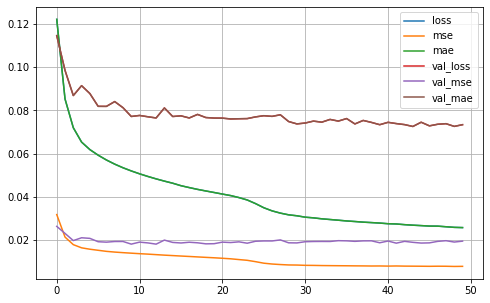

In [19]:
plot_train_history(evo_history_single_var,
                   'Training and validation loss')

In [20]:
save_performance_to_txt("Evo_Single_Variable",
                        evo_val_single_var,
                        evo_model_single_var,
                        evo_history_single_var,
                        evo_data_single_var.travels.max(),
                        evo_data_single_var.travels.min())

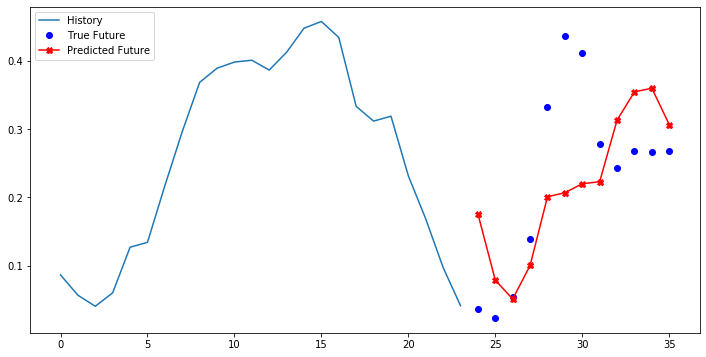

In [21]:
for x, y in evo_val_single_var.take(1):
    multi_step_plot(x[0], y[0], evo_model_single_var.predict(x)[0])

Evo Performance Univariavel (Hours Skiped = 12)



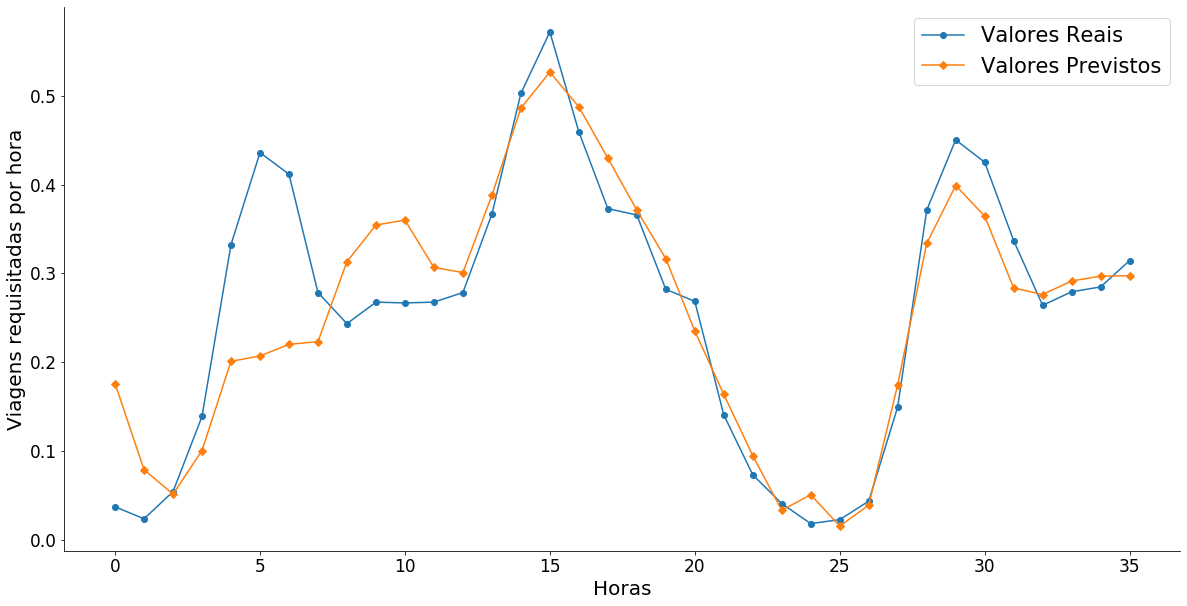

In [22]:
performance_representation_plot(12,
                                evo_val_single_var,
                                evo_model_single_var,
                                evo_data_single_var.travels.max(),
                                evo_data_single_var.travels.min(),
                                "Evo Performance Univariavel",
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,
                                denormalize=False)

### Multi Variable

In [23]:
print('Evo Model Multi Var')
evo_model, evo_history = lstm_model(evo_train,
                                    evo_val,
                                    evo_shape,
                                    epochs=50,
                                    node_number=80)

Evo Model Multi Var
(43, 12)
Train for 200 steps, validate for 50 steps
Epoch 1/50
200/200 [==============================] - 17s 87ms/step - loss: 0.1223 - mse: 0.0320 - mae: 0.1223 - val_loss: 0.1144 - val_mse: 0.0246 - val_mae: 0.1144
Epoch 2/50
200/200 [==============================] - 14s 70ms/step - loss: 0.0824 - mse: 0.0201 - mae: 0.0824 - val_loss: 0.1113 - val_mse: 0.0260 - val_mae: 0.1113
Epoch 3/50
200/200 [==============================] - 15s 75ms/step - loss: 0.0689 - mse: 0.0166 - mae: 0.0689 - val_loss: 0.1009 - val_mse: 0.0231 - val_mae: 0.1009
Epoch 4/50
200/200 [==============================] - 14s 70ms/step - loss: 0.0617 - mse: 0.0148 - mae: 0.0617 - val_loss: 0.0851 - val_mse: 0.0186 - val_mae: 0.0851
Epoch 5/50
200/200 [==============================] - 14s 70ms/step - loss: 0.0568 - mse: 0.0136 - mae: 0.0568 - val_loss: 0.0902 - val_mse: 0.0199 - val_mae: 0.0902
Epoch 6/50
200/200 [==============================] - 14s 69ms/step - loss: 0.0518 - mse: 0.0121 -

### Plotting prediction

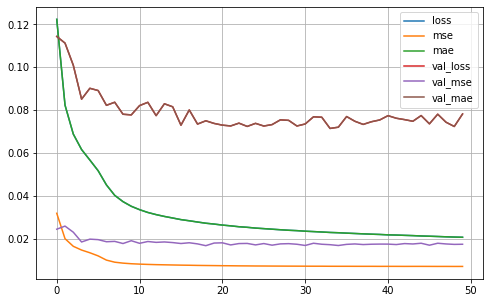

In [24]:
plot_train_history(evo_history,
                   'Training and validation loss')

In [25]:
save_performance_to_txt("Evo Multivariable",
                        evo_val,
                        evo_model,
                        evo_history,
                        evo_data.travels.max(),
                        evo_data.travels.min())

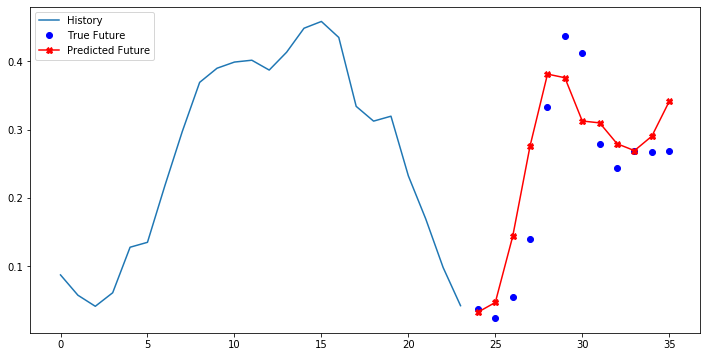

In [27]:
for x, y in evo_val.take(1):
    multi_step_plot(x[0], y[0], evo_model.predict(x)[0])

Evo Performance Multivariavel (Hours Skiped = 12)



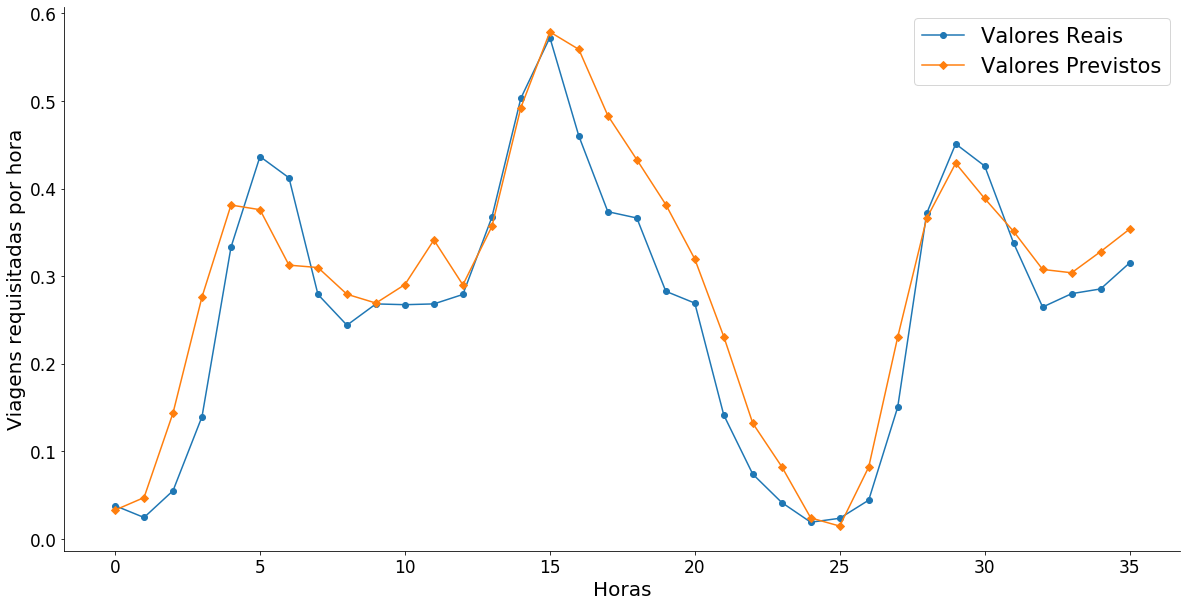

In [28]:
performance_representation_plot(12,
                                evo_val,
                                evo_model,
                                evo_data.travels.max(),
                                evo_data.travels.min(),
                                "Evo Performance Multivariavel",
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,
                                denormalize=False)

## Modo model

### Single Variable

In [29]:
print('Modo Model')
modo_model_single_var, modo_history_single_var = lstm_model(modo_train_single_var,
                                                            modo_val_single_var,
                                                            modo_shape_single_var,
                                                            epochs=50,
                                                            node_number=50)

Modo Model
(83, 12)
Train for 200 steps, validate for 50 steps
Epoch 1/50
200/200 [==============================] - 15s 74ms/step - loss: 0.0478 - mse: 0.0071 - mae: 0.0478 - val_loss: 0.0428 - val_mse: 0.0044 - val_mae: 0.0428
Epoch 2/50
200/200 [==============================] - 12s 58ms/step - loss: 0.0339 - mse: 0.0054 - mae: 0.0339 - val_loss: 0.0444 - val_mse: 0.0046 - val_mae: 0.0444
Epoch 3/50
200/200 [==============================] - 12s 60ms/step - loss: 0.0309 - mse: 0.0052 - mae: 0.0309 - val_loss: 0.0419 - val_mse: 0.0043 - val_mae: 0.0419
Epoch 4/50
200/200 [==============================] - 12s 60ms/step - loss: 0.0295 - mse: 0.0051 - mae: 0.0295 - val_loss: 0.0412 - val_mse: 0.0044 - val_mae: 0.0412
Epoch 5/50
200/200 [==============================] - 12s 59ms/step - loss: 0.0285 - mse: 0.0050 - mae: 0.0285 - val_loss: 0.0419 - val_mse: 0.0044 - val_mae: 0.0419
Epoch 6/50
200/200 [==============================] - 12s 59ms/step - loss: 0.0279 - mse: 0.0050 - mae: 0.0

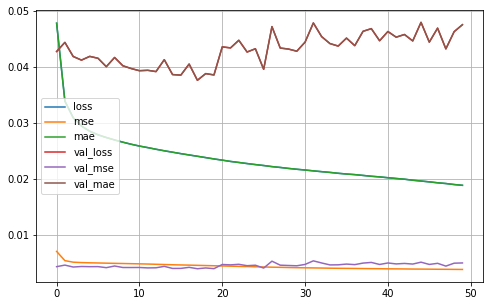

In [30]:
plot_train_history(modo_history_single_var,
                   'Training and validation loss')

In [31]:
save_performance_to_txt("Modo_Single_Variable",
                        modo_val_single_var,
                        modo_model_single_var,
                        modo_history_single_var,
                        modo_data_single_var.travels.max(),
                        modo_data_single_var.travels.min())

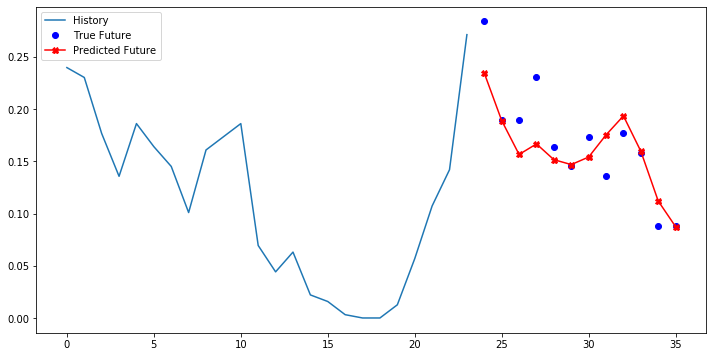

In [32]:
for x, y in modo_val_single_var.take(1):
    multi_step_plot(x[0], y[0], modo_model_single_var.predict(x)[0])

Modo Performance Univariavel (Hours Skiped = 12)



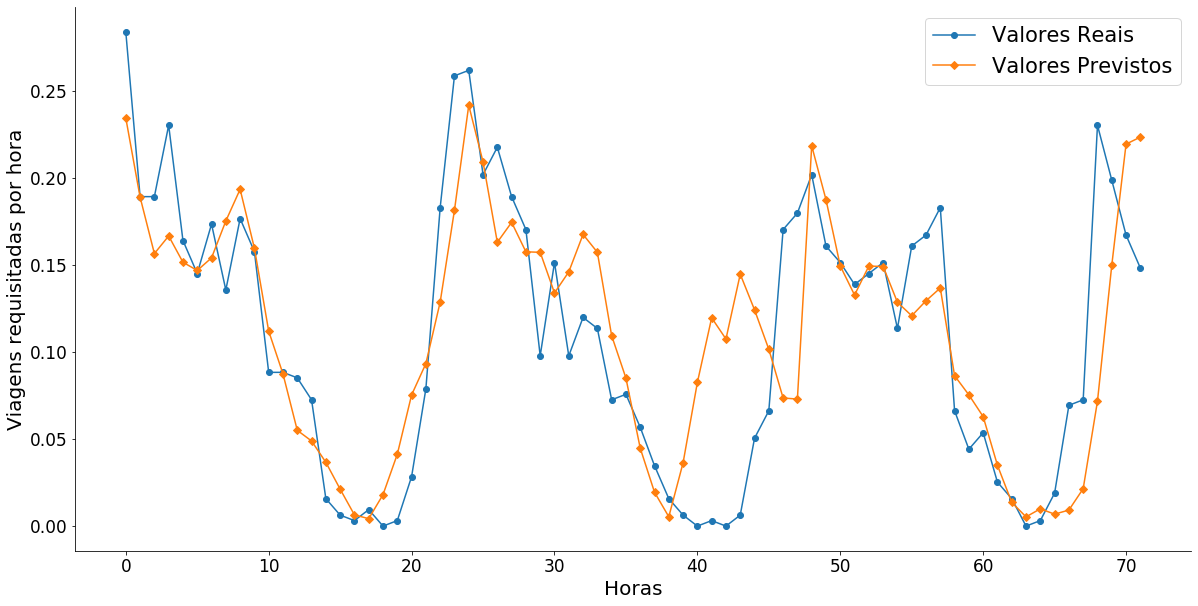

In [33]:
performance_representation_plot(12,
                                modo_val_single_var,
                                modo_model_single_var,
                                modo_data_single_var.travels.max(),
                                modo_data_single_var.travels.min(),
                                "Modo Performance Univariavel",
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,
                                denormalize=False)

### Multi Variable

In [34]:
print('Modo Model')
modo_model, modo_history = lstm_model(modo_train,
                                      modo_val,
                                      modo_shape,
                                      epochs=50,
                                      node_number=80)

Modo Model
(83, 12)
Train for 200 steps, validate for 50 steps
Epoch 1/50
200/200 [==============================] - 22s 110ms/step - loss: 0.0433 - mse: 0.0066 - mae: 0.0433 - val_loss: 0.0429 - val_mse: 0.0045 - val_mae: 0.0429
Epoch 2/50
200/200 [==============================] - 16s 81ms/step - loss: 0.0311 - mse: 0.0051 - mae: 0.0311 - val_loss: 0.0401 - val_mse: 0.0042 - val_mae: 0.0401
Epoch 3/50
200/200 [==============================] - 16s 79ms/step - loss: 0.0283 - mse: 0.0049 - mae: 0.0283 - val_loss: 0.0403 - val_mse: 0.0043 - val_mae: 0.0403
Epoch 4/50
200/200 [==============================] - 16s 80ms/step - loss: 0.0266 - mse: 0.0047 - mae: 0.0266 - val_loss: 0.0410 - val_mse: 0.0043 - val_mae: 0.0410
Epoch 5/50
200/200 [==============================] - 16s 79ms/step - loss: 0.0254 - mse: 0.0045 - mae: 0.0254 - val_loss: 0.0367 - val_mse: 0.0039 - val_mae: 0.0367
Epoch 6/50
200/200 [==============================] - 16s 79ms/step - loss: 0.0243 - mse: 0.0044 - mae: 0.

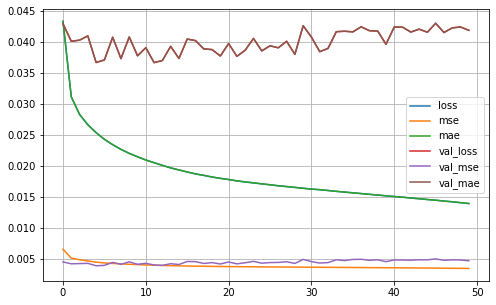

In [35]:
plot_train_history(modo_history,
                   'Training and validation loss')

In [36]:
save_performance_to_txt("Modo Multivariable",
                        modo_val,
                        modo_model,
                        modo_history,
                        modo_data.travels.max(),
                        modo_data.travels.min())

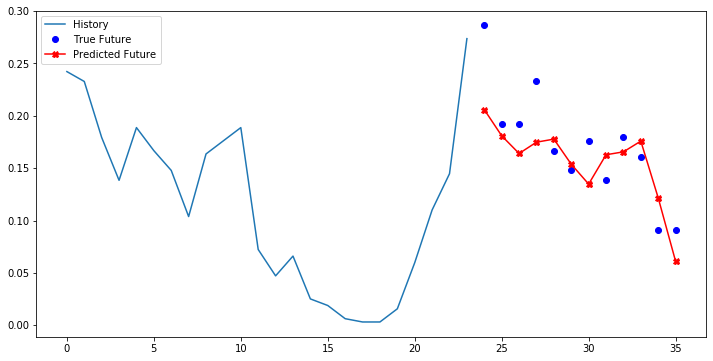

In [37]:
for x, y in modo_val.take(1):
    multi_step_plot(x[0], y[0], modo_model.predict(x)[0])

Modo Performance Multivariavel (Hours Skiped = 12)



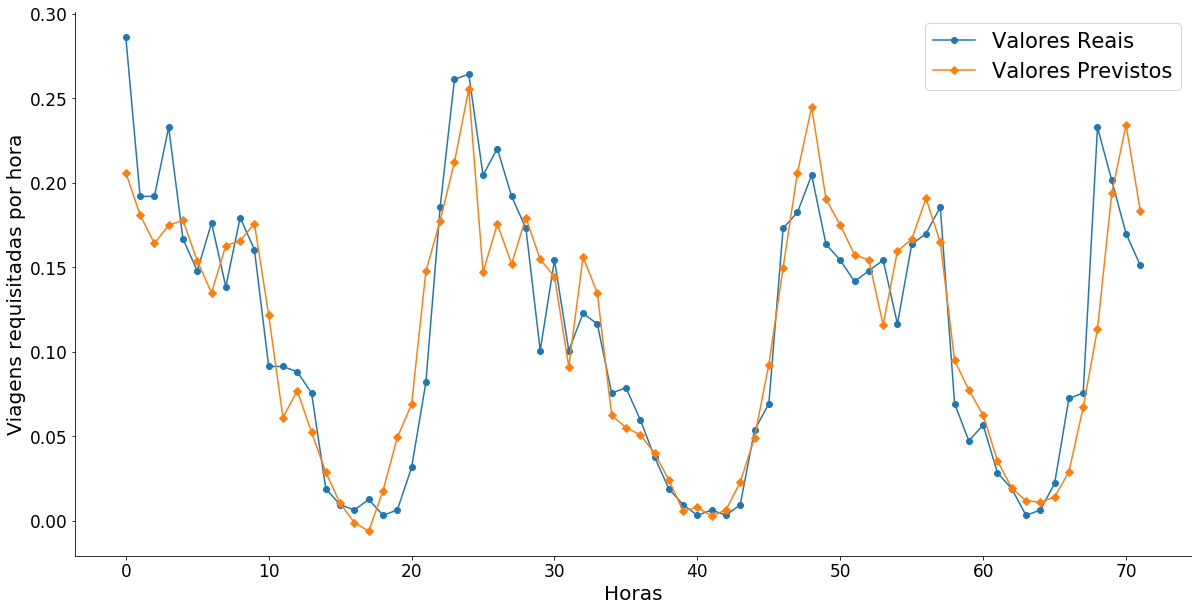

In [38]:
performance_representation_plot(12,
                                modo_val,
                                modo_model,
                                modo_data.travels.max(),
                                modo_data.travels.min(),
                                "Modo Performance Multivariavel",
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,
                                denormalize=False)

## Car2Go Model

### Single Variable

In [39]:
print('Car2Go Model')
c2g_model_single_var, c2g_history_single_var = lstm_model(c2g_train_single_var,
                                                          c2g_val_single_var,
                                                          c2g_shape_single_var,
                                                          epochs=50,
                                                          node_number=50)

Car2Go Model
(96, 12)
Train for 200 steps, validate for 50 steps
Epoch 1/50
200/200 [==============================] - 13s 63ms/step - loss: 0.1817 - mse: 0.0530 - mae: 0.1821 - val_loss: 0.1291 - val_mse: 0.0293 - val_mae: 0.1291
Epoch 2/50
200/200 [==============================] - 8s 41ms/step - loss: 0.1220 - mse: 0.0286 - mae: 0.1224 - val_loss: 0.1077 - val_mse: 0.0198 - val_mae: 0.1077
Epoch 3/50
200/200 [==============================] - 8s 41ms/step - loss: 0.1090 - mse: 0.0249 - mae: 0.1107 - val_loss: 0.0994 - val_mse: 0.0177 - val_mae: 0.0994
Epoch 4/50
200/200 [==============================] - 8s 41ms/step - loss: 0.1039 - mse: 0.0232 - mae: 0.1048 - val_loss: 0.0884 - val_mse: 0.0137 - val_mae: 0.0884
Epoch 5/50
200/200 [==============================] - 8s 42ms/step - loss: 0.0982 - mse: 0.0220 - mae: 0.1000 - val_loss: 0.0883 - val_mse: 0.0130 - val_mae: 0.0883
Epoch 6/50
200/200 [==============================] - 8s 42ms/step - loss: 0.0944 - mse: 0.0204 - mae: 0.0954

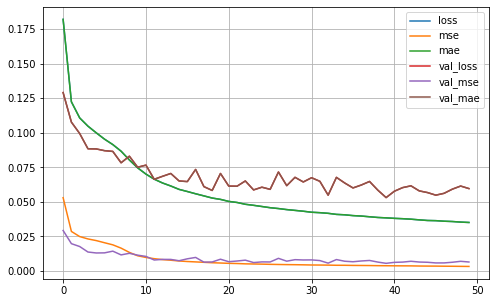

In [40]:
plot_train_history(c2g_history_single_var,
                   'Training and validation loss')

In [41]:
save_performance_to_txt("Car2Go_Single_Variable",
                        c2g_val_single_var,
                        c2g_model_single_var,
                        c2g_history_single_var,
                        c2g_data_single_var.travels.max(),
                        c2g_data_single_var.travels.min())

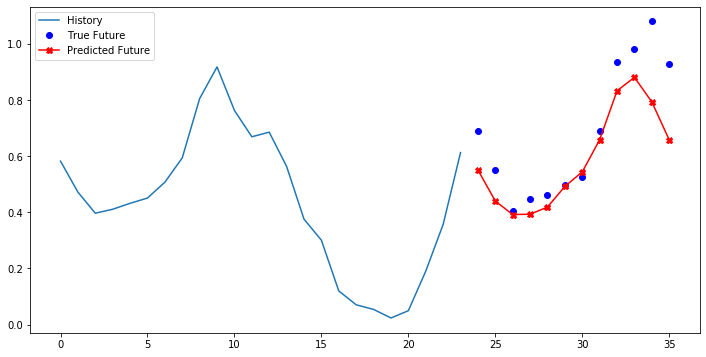

In [42]:
for x, y in c2g_val_single_var.take(1):
    multi_step_plot(x[0], y[0],c2g_model_single_var.predict(x)[0])

Car2Go Performance Univariável (Hours Skiped = 12)



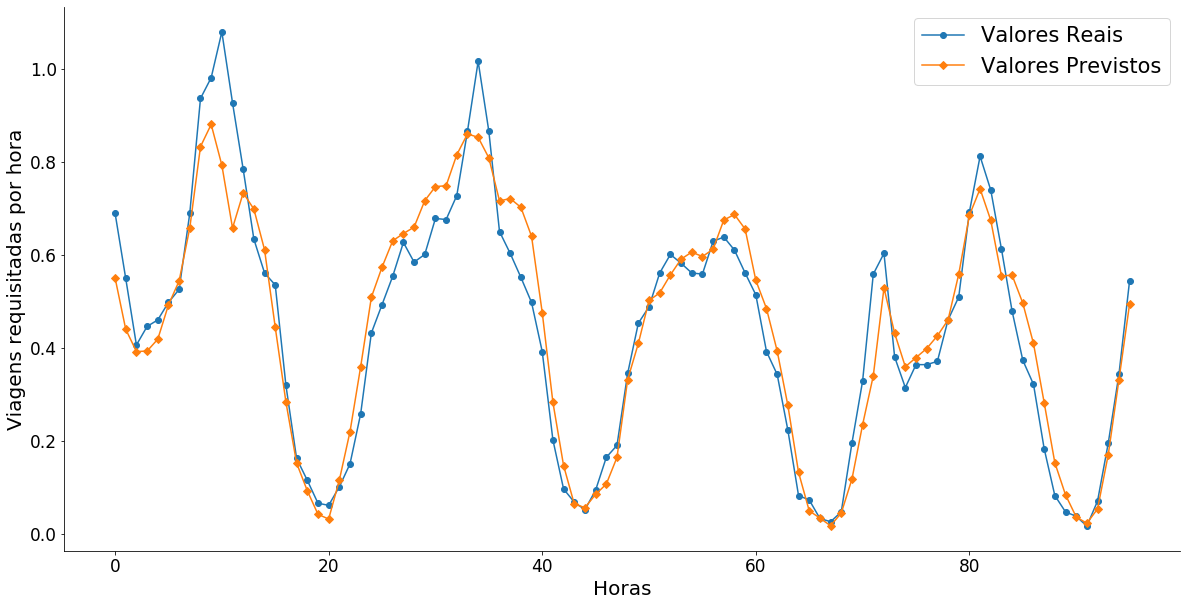

In [43]:
performance_representation_plot(12,
                                c2g_val_single_var,
                                c2g_model_single_var,
                                c2g_data_single_var.travels.max(),
                                c2g_data_single_var.travels.min(),
                                "Car2Go Performance Univariável",
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,
                                denormalize=False)

### Multi Variable

In [44]:
print('Car2Go Model')
c2g_model, c2g_history = lstm_model(c2g_train, c2g_val, c2g_shape,  epochs=50, node_number=80)

Car2Go Model
(96, 12)
Train for 200 steps, validate for 50 steps
Epoch 1/50
200/200 [==============================] - 14s 69ms/step - loss: 0.1780 - mse: 0.0534 - mae: 0.1790 - val_loss: 0.1149 - val_mse: 0.0241 - val_mae: 0.1149
Epoch 2/50
200/200 [==============================] - 11s 54ms/step - loss: 0.1158 - mse: 0.0271 - mae: 0.1170 - val_loss: 0.1022 - val_mse: 0.0191 - val_mae: 0.1022
Epoch 3/50
200/200 [==============================] - 11s 54ms/step - loss: 0.1047 - mse: 0.0233 - mae: 0.1056 - val_loss: 0.1042 - val_mse: 0.0174 - val_mae: 0.1042
Epoch 4/50
200/200 [==============================] - 11s 53ms/step - loss: 0.0988 - mse: 0.0213 - mae: 0.0995 - val_loss: 0.0831 - val_mse: 0.0121 - val_mae: 0.0831
Epoch 5/50
200/200 [==============================] - 10s 52ms/step - loss: 0.0911 - mse: 0.0186 - mae: 0.0922 - val_loss: 0.0779 - val_mse: 0.0108 - val_mae: 0.0779mse: 0.0188 - 
Epoch 6/50
200/200 [==============================] - 11s 54ms/step - loss: 0.0835 - mse: 0

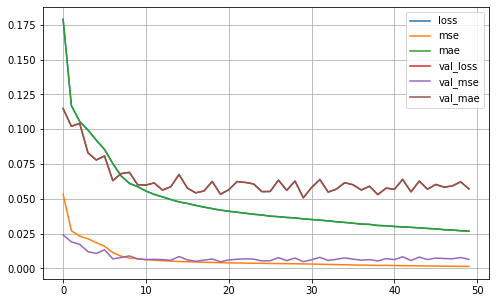

In [45]:
plot_train_history(c2g_history,
                   'Training and validation loss')

In [46]:
save_performance_to_txt("Car2Go Multivariable",
                        c2g_val,
                        c2g_model,
                        c2g_history,
                        c2g_data.travels.max(),
                        c2g_data.travels.min())

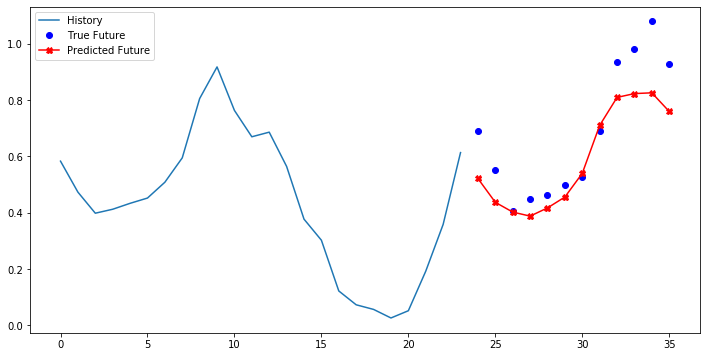

In [47]:
for x, y in c2g_val.take(1):
    multi_step_plot(x[0], y[0],c2g_model.predict(x)[0])

Car2Go Performance Multivariavel (Hours Skiped = 12)



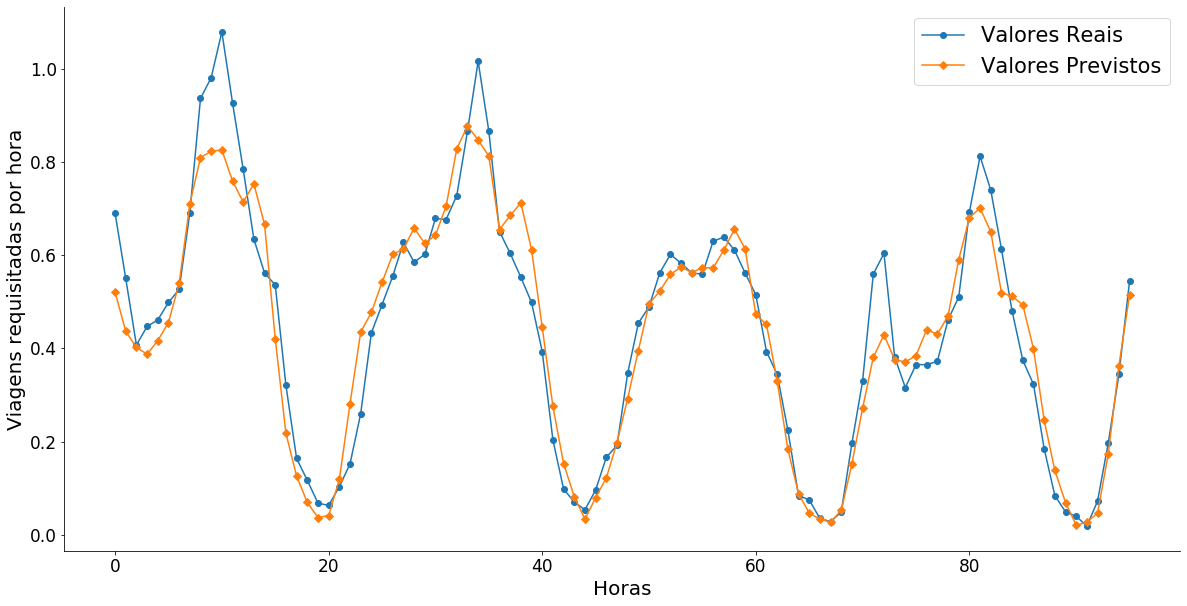

In [48]:
performance_representation_plot(12,
                                c2g_val,
                                c2g_model,
                                c2g_data.travels.max(),
                                c2g_data.travels.min(),
                                "Car2Go Performance Multivariavel",
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,
                                denormalize=False)

performance_representation_plotrences

* https://www.tensorflow.org/tutorials/structured_data/time_series#part_2_forecast_a_multivariate_time_series
* http://netlab.ice.ufjf.br/index.php/carsharingdata/